In [1]:
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
import os
import torch
from coati.common.util import batch_indexable
from rdkit import Chem
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from coati.models.regression.basic_due import basic_due
from coati.utils.chem import rm_radical, token_clean, rdkit_normal_smi, read_pkl, read_sdf, write_sdf
from glob import glob
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from tqdm import tqdm
import os.path as osp
def read_txt(file):
    with open(file, 'r') as f:
        data = f.read().splitlines()
    return data

def fp_list_from_smiles_list(smiles_list,n_bits=2048):
    fp_list = []
    for smiles in tqdm(smiles_list):
        try:
            mol = Chem.MolFromSmiles(smiles)
            fp_list.append(fp_as_array(mol,n_bits))
        except Exception as e:
            pass
    return fp_list

def fp_as_array(mol,n_bits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=n_bits)
    arr = np.zeros((1,),int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

In [8]:

def embed_and_score_in_batches_regression(
    records,
    encoder,
    tokenizer,
    batch_size=128,
    score=True,
    smiles_field="smiles",
):

    print("Embedding and scoring iterable from smiles.")
    batch_iter = batch_indexable(records, batch_size)
    num_batches = len(records) // batch_size
    with torch.no_grad():
        for i, batch in enumerate(batch_iter):
            print(f"batch: {i}/{num_batches}")
            try:
                batch_mols = [Chem.MolFromSmiles(row[smiles_field]) for row in batch]
                batch_smiles = [Chem.MolToSmiles(m) for m in batch_mols]
                batch_tokens = torch.tensor(
                    [
                        tokenizer.tokenize_text("[SMILES]" + s + "[STOP]", pad=True)
                        if s != "*"
                        else tokenizer.tokenize_text("[SMILES]C[STOP]", pad=True)
                        for s in batch_smiles
                    ],
                    device=encoder.device,
                    dtype=torch.int,
                )
                batch_embeds = encoder.encode_tokens(batch_tokens, tokenizer)
                if score:
                    batch_logp = [Chem.Crippen.MolLogP(m) for m in batch_mols]
                    batch_qed = [Chem.QED.qed(m) for m in batch_mols]
                if len(batch) < 2:
                    batch[0]["emb_smiles"] = batch_embeds[0].detach().cpu().numpy()
                    if score:
                        batch[0]["qed"] = batch_qed[0]
                        batch[0]["logp"] = batch_logp[0]
                        batch[0]["smiles"] = batch_smiles[0]
                else:
                    for k, r in enumerate(batch):
                        batch[k]["emb_smiles"] = batch_embeds[k].detach().cpu().numpy()
                        if score:
                            batch[k]["qed"] = batch_qed[k]
                            batch[k]["logp"] = batch_logp[k]
                            batch[k]["smiles"] = batch_smiles[k]
            except Exception as Ex:
                print(Ex)
                continue

In [9]:

DEVICE = torch.device('cuda')
encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=DEVICE,
    doc_url='./model_ckpts/ecloud_augmented_37.pkl',
)


Loading model from ./model_ckpts/ecloud_augmented_37.pkl
Loading tokenizer mar from ./model_ckpts/ecloud_augmented_37.pkl
number of parameters: 12.64M
number of parameters Total: 2.44M xformer: 19.60M Total: 22.04M 
Freezing encoder
44882816 params frozen!


In [10]:
data = read_txt('./examples/conditions/target_ic50/mk14.txt')
ori_smi_pic50 = [{'smiles': i.split(',')[0], 'pic50':float(i.split(',')[1])} for i in data]
act_smi_pic50 = [i for i in ori_smi_pic50 if i['pic50'] > 4]

pdbbind = torch.load('./model_ckpts/conditions/pdbbind_4bel_cached.pt')

In [11]:
embed_and_score_in_batches_regression(act_smi_pic50, encoder, tokenizer)

Embedding and scoring iterable from smiles.
batch: 0/4
batch: 1/4
batch: 2/4
batch: 3/4
batch: 4/4


In [12]:
torch.save(act_smi_pic50, './model_ckpts/conditions/mk14.pt')

In [6]:
base = './results/conditions_tmp/'

traj = read_pkl('./results/conditions_tmp/pic50_0.pkl')[1:]

traj_files = glob('./results/conditions_tmp/*.pkl')
traj = []
for i in traj_files:
    traj += read_pkl(i)[1:]

In [7]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

data = np.array([i['emb'] for i in traj])
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data)


KeyError: 'emb'

In [131]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns


data1 = np.array([i['emb_smiles'] for i in act_smi_pic50])
data2 = np.array([i['emb'] for i in traj])



# 合并数据集
combined_data = np.vstack([data1, data2])

# 执行 t-SNE
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(combined_data)

# 分割 t-SNE 结果
tsne_data1 = tsne_results[:len(data1), :]
tsne_data2 = tsne_results[len(data1):, :]


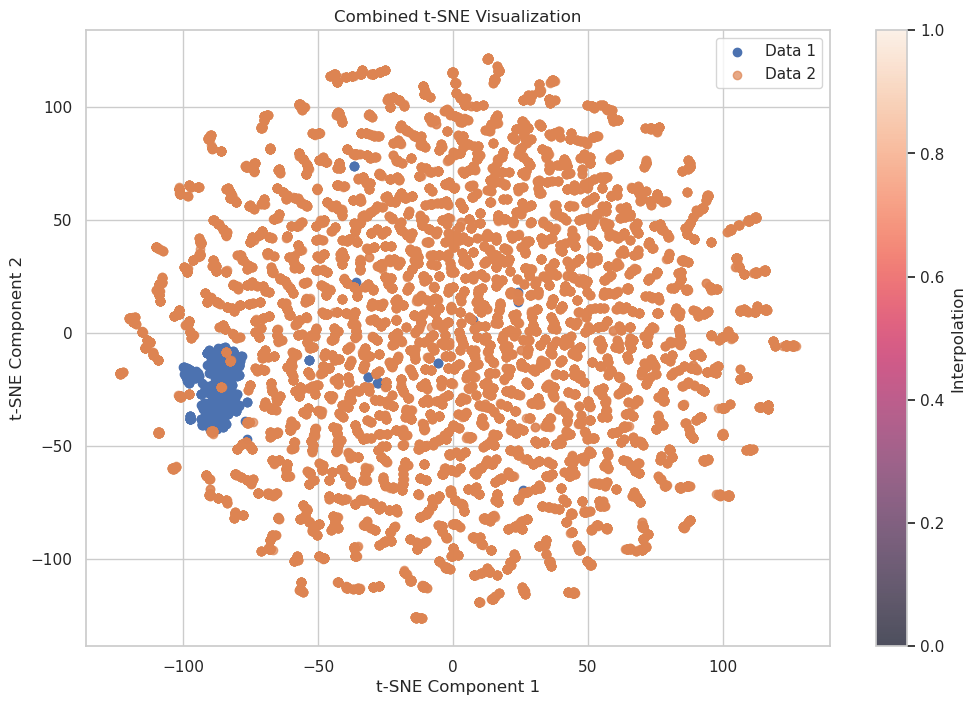

In [136]:
sns.set(style="whitegrid")  # 设置 seaborn 样式

palette = sns.color_palette("deep", 2) 
plt.figure(figsize=(12, 8))
plt.scatter(tsne_data1[:, 0], tsne_data1[:, 1], color=palette[0], label='Data 1')
plt.scatter(tsne_data2[:, 0], tsne_data2[:, 1], color=palette[1], label='Data 2', alpha=0.7)

plt.title('Combined t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Interpolation')  # 显示颜色条
plt.legend()
plt.show()


In [ ]:
# use ecloud chemical space
data1 = np.array([i['emb_smiles'] for i in pdbbind])
data2 = np.array([i['emb_smiles'] for i in act_smi_pic50])
data3 = np.array([i['emb'] for i in traj])
combined_data = np.vstack([data1, data2, data3])

In [188]:
# use rdkit fingerprint
smi1 = [i['smiles'] for i in pdbbind]
smi2 = [i['smiles'] for i in act_smi_pic50]
smi3 = [i['smiles'] for i in traj]
data1 = np.array(fp_list_from_smiles_list(smi1))
data2 = np.array(fp_list_from_smiles_list(smi2))
data3 = np.array(fp_list_from_smiles_list(smi3))

100%|██████████| 20500/20500 [00:02<00:00, 7439.36it/s]


In [163]:


# 执行 t-SNE
tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(combined_data)

# 分割 t-SNE 结果
tsne_data1 = tsne_results[:len(data1), :]
tsne_data2 = tsne_results[len(data1):len(data1)+len(data2), :]
tsne_data3 = tsne_results[len(data1)+len(data2):, :]

In [149]:


combined_data = np.vstack([data1, data2, data3])

# 执行 t-SNE
tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(combined_data)

# 分割 t-SNE 结果
tsne_data1 = tsne_results[:len(data1), :]
tsne_data2 = tsne_results[len(data1):len(data1)+len(data2), :]
tsne_data3 = tsne_results[len(data1)+len(data2):, :]

100%|██████████| 20500/20500 [00:02<00:00, 7438.75it/s]


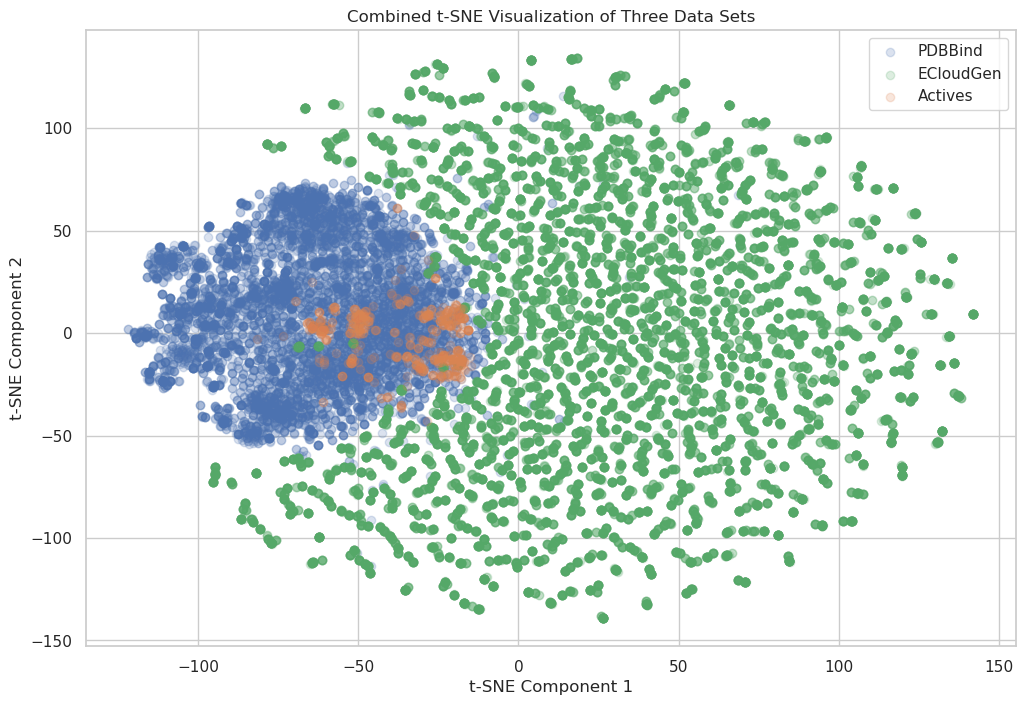

In [164]:
sns.set(style="whitegrid")  # 设置 seaborn 样式

# 使用 Seaborn 的 "deep" 调色板
palette = sns.color_palette("deep", 3)

plt.figure(figsize=(12, 8))
plt.scatter(tsne_data1[:, 0], tsne_data1[:, 1], color=palette[0], label='PDBBind', alpha=0.2)
plt.scatter(tsne_data3[:, 0], tsne_data3[:, 1], color=palette[2], label='ECloudGen', alpha=0.2)
plt.scatter(tsne_data2[:, 0], tsne_data2[:, 1], color=palette[1], label='Actives', alpha=0.2)

plt.title('Combined t-SNE Visualization of Three Data Sets')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()


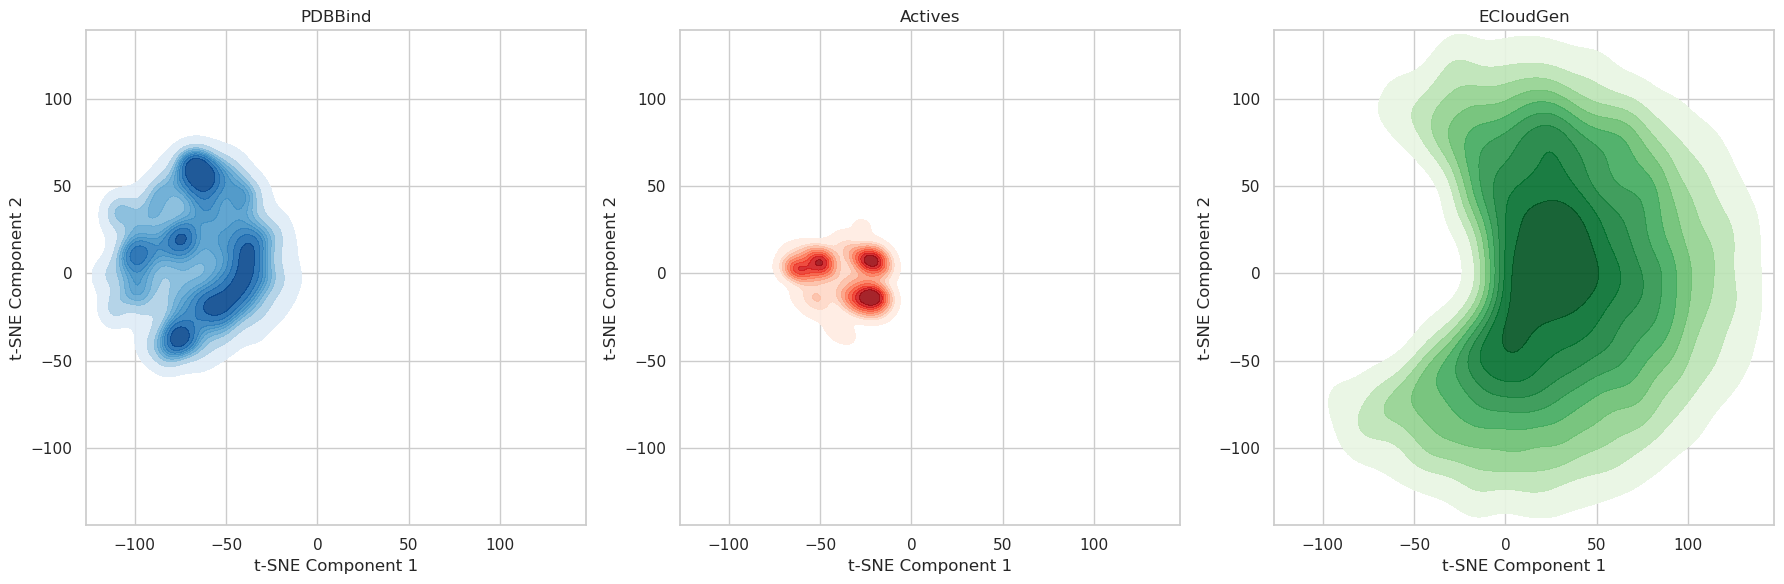

In [165]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 计算所有数据的整体最小值和最大值
all_data = np.vstack([tsne_data1, tsne_data2, tsne_data3])
x_min, x_max = all_data[:, 0].min(), all_data[:, 0].max()
y_min, y_max = all_data[:, 1].min(), all_data[:, 1].max()

# 为了留出一些边缘空间，可以稍微扩展这个范围
x_range = [x_min - 5, x_max + 5]
y_range = [y_min - 5, y_max + 5]

# 绘图
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1行3列

# Data 1
sns.kdeplot(x=tsne_data1[:, 0], y=tsne_data1[:, 1], ax=axes[0], cmap="Blues", fill=True, alpha=0.9)
axes[0].set_title('PDBBind')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
axes[0].set_xlim(x_range)
axes[0].set_ylim(y_range)

# Data 2
sns.kdeplot(x=tsne_data2[:, 0], y=tsne_data2[:, 1], ax=axes[1], cmap="Reds", fill=True, alpha=0.9)
axes[1].set_title('Actives')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].set_xlim(x_range)
axes[1].set_ylim(y_range)

# Data 3
sns.kdeplot(x=tsne_data3[:, 0], y=tsne_data3[:, 1], ax=axes[2], cmap="Greens", fill=True, alpha=0.9)
axes[2].set_title('ECloudGen')
axes[2].set_xlabel('t-SNE Component 1')
axes[2].set_ylabel('t-SNE Component 2')
axes[2].set_xlim(x_range)
axes[2].set_ylim(y_range)

plt.tight_layout()
plt.show()


In [168]:
from openTSNE import TSNE
from sklearn.datasets import load_digits

# 假设 data3 是用于训练的数据集
# data1 和 data2 是需要映射的数据集
tsne = TSNE(n_components=2, perplexity=30, metric='cosine', random_state=42)

# 首先训练 t-SNE 模型
embedded_data3 = tsne.fit(data3)

# 使用相同的模型映射新数据
embedded_data1 = embedded_data3.transform(data1)
embedded_data2 = embedded_data3.transform(data2)


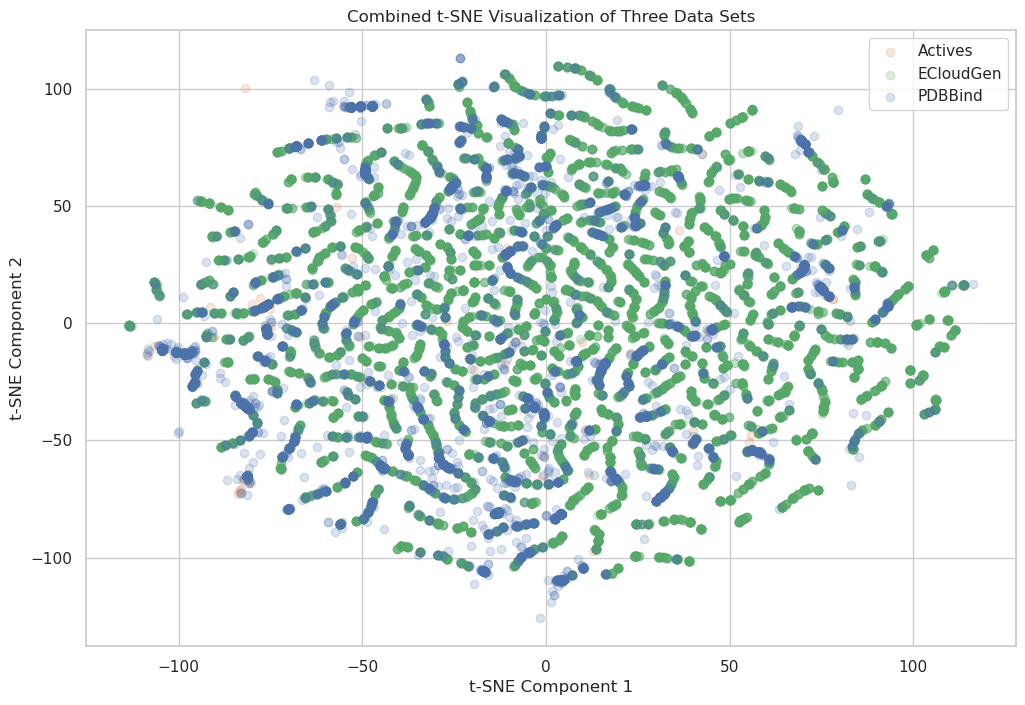

In [173]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have transformed tsne_data1, tsne_data2, and tsne_data3
# If these are the names of your datasets after embedding, replace below accordingly
# Assuming tsne_dataX are the embedded dataset variables from the previous discussion

sns.set(style="whitegrid")  # Setting Seaborn style for better grid visibility

# Using Seaborn's "deep" color palette for distinct color per dataset
palette = sns.color_palette("deep", 3)

# Initialize the plot with specified figure size
plt.figure(figsize=(12, 8))

# Plotting each dataset with specified colors and transparency
plt.scatter(embedded_data2[:, 0], embedded_data2[:, 1], color=palette[1], label='Actives', alpha=0.2)
plt.scatter(embedded_data3[:, 0], embedded_data3[:, 1], color=palette[2], label='ECloudGen', alpha=0.2)
plt.scatter(embedded_data1[:, 0], embedded_data1[:, 1], color=palette[0], label='PDBBind', alpha=0.2)
# Adding title and labels
plt.title('Combined t-SNE Visualization of Three Data Sets')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Displaying the legend to identify datasets
plt.legend()

# Display the plot
plt.show()


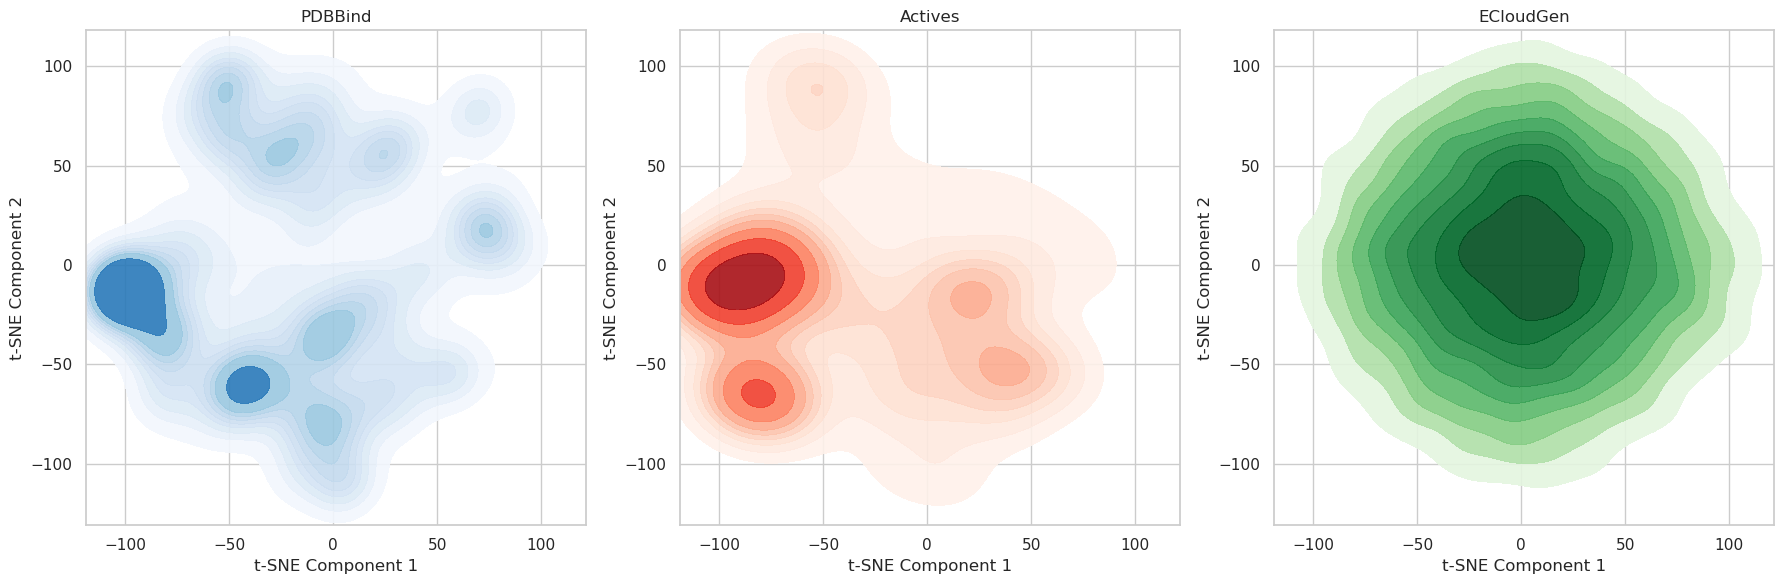

In [170]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming embedded_data1, embedded_data2, embedded_data3 are the transformed datasets
# Calculating the overall min and max for the plotting ranges
all_data = np.vstack([embedded_data1, embedded_data2, embedded_data3])
x_min, x_max = all_data[:, 0].min(), all_data[:, 0].max()
y_min, y_max = all_data[:, 1].min(), all_data[:, 1].max()

# Extending the range slightly for visual comfort
x_range = [x_min - 5, x_max + 5]
y_range = [y_min - 5, y_max + 5]

# Setup the plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Data 1 Plot
sns.kdeplot(x=embedded_data1[:, 0], y=embedded_data1[:, 1], ax=axes[0], cmap="Blues", fill=True, alpha=0.9)
axes[0].set_title('PDBBind')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
axes[0].set_xlim(x_range)
axes[0].set_ylim(y_range)

# Data 2 Plot
sns.kdeplot(x=embedded_data2[:, 0], y=embedded_data2[:, 1], ax=axes[1], cmap="Reds", fill=True, alpha=0.9)
axes[1].set_title('Actives')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].set_xlim(x_range)
axes[1].set_ylim(y_range)

# Data 3 Plot
sns.kdeplot(x=embedded_data3[:, 0], y=embedded_data3[:, 1], ax=axes[2], cmap="Greens", fill=True, alpha=0.9)
axes[2].set_title('ECloudGen')
axes[2].set_xlabel('t-SNE Component 1')
axes[2].set_ylabel('t-SNE Component 2')
axes[2].set_xlim(x_range)
axes[2].set_ylim(y_range)

plt.tight_layout()
plt.show()


In [189]:
from openTSNE import TSNE
from sklearn.datasets import load_digits

# 假设 data3 是用于训练的数据集
# data1 和 data2 是需要映射的数据集
tsne = TSNE(n_components=2, perplexity=30, metric='cosine', random_state=42)

# 首先训练 t-SNE 模型
embedded_data1 = tsne.fit(data1)

# 使用相同的模型映射新数据
embedded_data2 = embedded_data1.transform(data2)
embedded_data3 = embedded_data1.transform(data3)


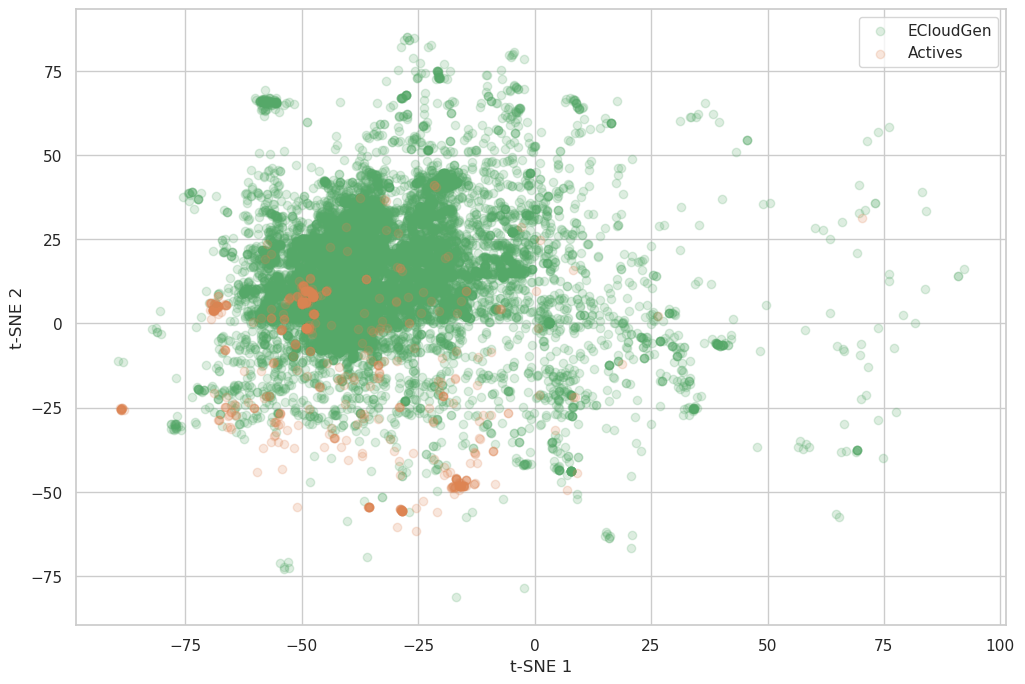

In [194]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have transformed tsne_data1, tsne_data2, and tsne_data3
# If these are the names of your datasets after embedding, replace below accordingly
# Assuming tsne_dataX are the embedded dataset variables from the previous discussion

sns.set(style="whitegrid")  # Setting Seaborn style for better grid visibility

# Using Seaborn's "deep" color palette for distinct color per dataset
palette = sns.color_palette("deep", 3)

# Initialize the plot with specified figure size
plt.figure(figsize=(12, 8))

# Plotting each dataset with specified colors and transparency
plt.scatter(embedded_data3[:, 0], embedded_data3[:, 1], color=palette[2], label='ECloudGen', alpha=0.2)# Adding title and labels
plt.scatter(embedded_data2[:, 0], embedded_data2[:, 1], color=palette[1], label='Actives', alpha=0.2)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# Displaying the legend to identify datasets
plt.legend()

# Display the plot
plt.show()


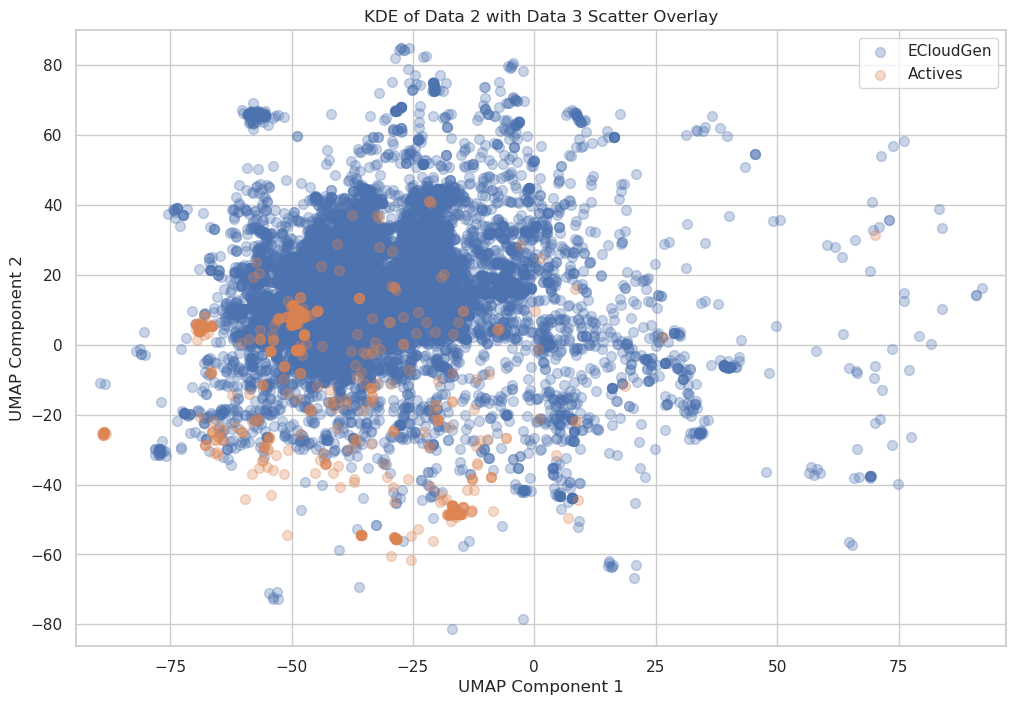

In [208]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming embedded_data2 and embedded_data3 are your transformed datasets
# Calculate the overall min and max for the plotting ranges
all_data = np.vstack([embedded_data2, embedded_data3])  # Only consider data2 and data3
x_min, x_max = all_data[:, 0].min(), all_data[:, 0].max()
y_min, y_max = all_data[:, 1].min(), all_data[:, 1].max()

palette = sns.color_palette("deep", 3)

# Extending the range slightly for visual comfort
x_range = [x_min - 5, x_max + 5]
y_range = [y_min - 5, y_max + 5]

# Setup the plot
plt.figure(figsize=(12, 8))

# Data 2 KDE Plot


plt.title('KDE of Data 2 with Data 3 Scatter Overlay')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.scatter(embedded_data3[:, 0], embedded_data3[:, 1], color=palette[0], label='ECloudGen', alpha=0.3, s=50)
plt.scatter(embedded_data2[:, 0], embedded_data2[:, 1], color=palette[1], label='Actives', alpha=0.3, s=50)
plt.xlim(x_range)
plt.ylim(y_range)

# Overlay Data 3 as Scatter Plot
plt.legend()

plt.show()


/home/haotian/software/miniconda3/envs/ecloud/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


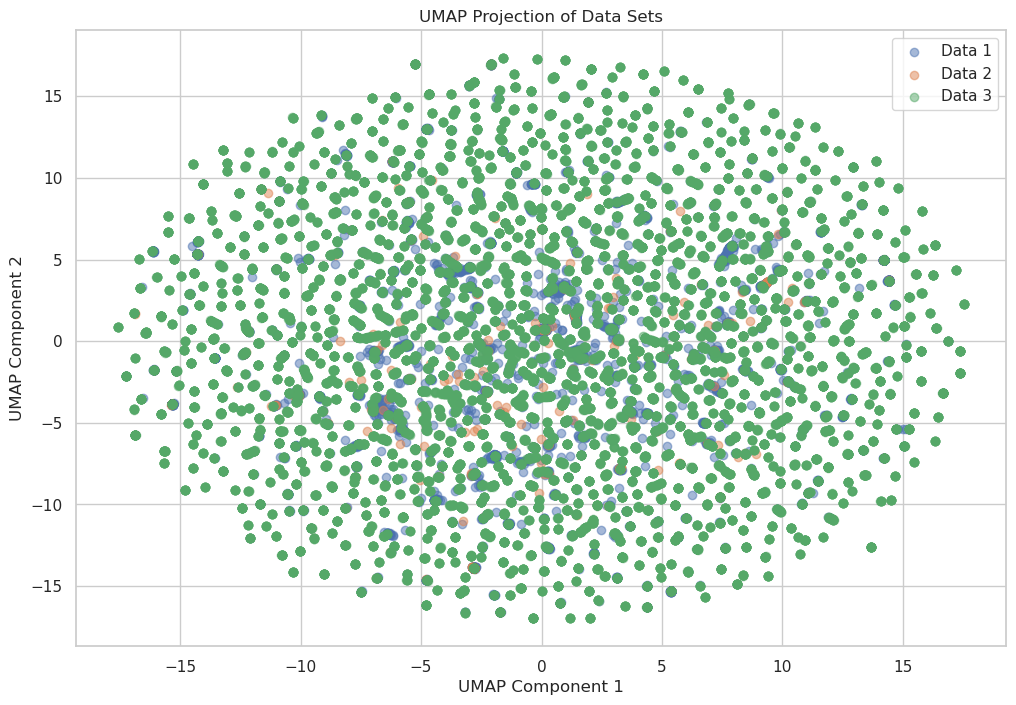

In [177]:
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 data1, data2, data3 是你的数据集

reducer = umap.UMAP(random_state=42)
embedded_data3 = reducer.fit_transform(data3)  # 使用 data3 拟合并转换

# 假设你还想转换 data1 和 data2
embedded_data1 = reducer.transform(data1)
embedded_data2 = reducer.transform(data2)

# 绘制结果
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
plt.scatter(embedded_data1[:, 0], embedded_data1[:, 1], label='Data 1', alpha=0.5)
plt.scatter(embedded_data2[:, 0], embedded_data2[:, 1], label='Data 2', alpha=0.5)
plt.scatter(embedded_data3[:, 0], embedded_data3[:, 1], label='Data 3', alpha=0.5)
plt.title('UMAP Projection of Data Sets')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()


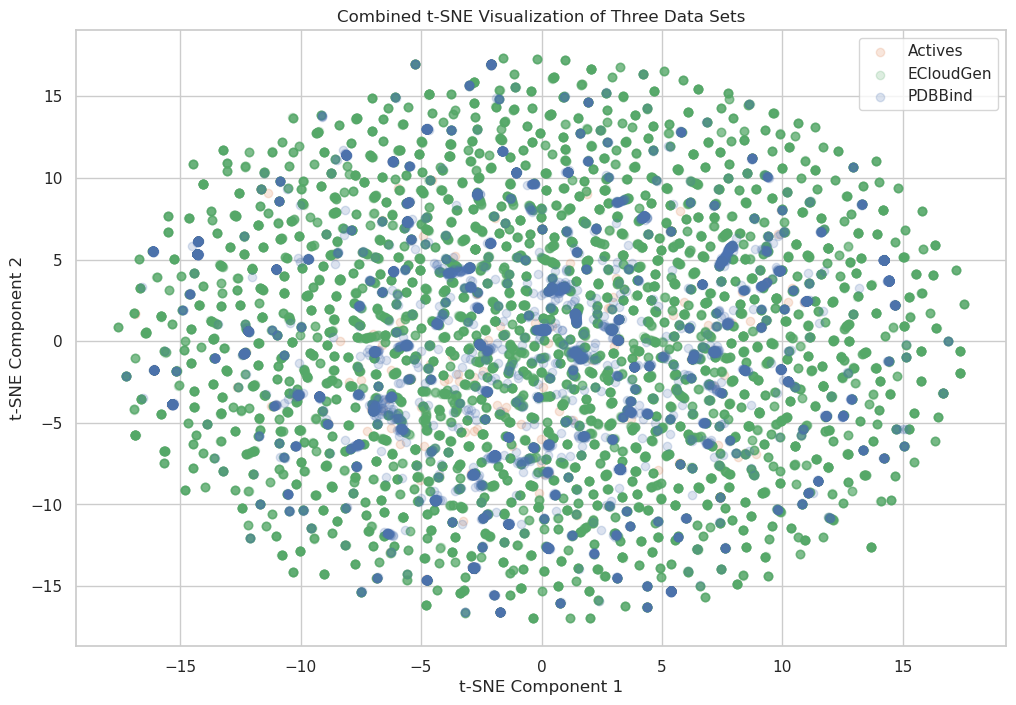

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have transformed tsne_data1, tsne_data2, and tsne_data3
# If these are the names of your datasets after embedding, replace below accordingly
# Assuming tsne_dataX are the embedded dataset variables from the previous discussion

sns.set(style="whitegrid")  # Setting Seaborn style for better grid visibility

# Using Seaborn's "deep" color palette for distinct color per dataset
palette = sns.color_palette("deep", 3)

# Initialize the plot with specified figure size
plt.figure(figsize=(12, 8))

# Plotting each dataset with specified colors and transparency
plt.scatter(embedded_data2[:, 0], embedded_data2[:, 1], color=palette[1], label='Actives', alpha=0.2)
plt.scatter(embedded_data3[:, 0], embedded_data3[:, 1], color=palette[2], label='ECloudGen', alpha=0.2)
plt.scatter(embedded_data1[:, 0], embedded_data1[:, 1], color=palette[0], label='PDBBind', alpha=0.2)
# Adding title and labels
plt.title('Combined t-SNE Visualization of Three Data Sets')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Displaying the legend to identify datasets
plt.legend()

# Display the plot
plt.show()


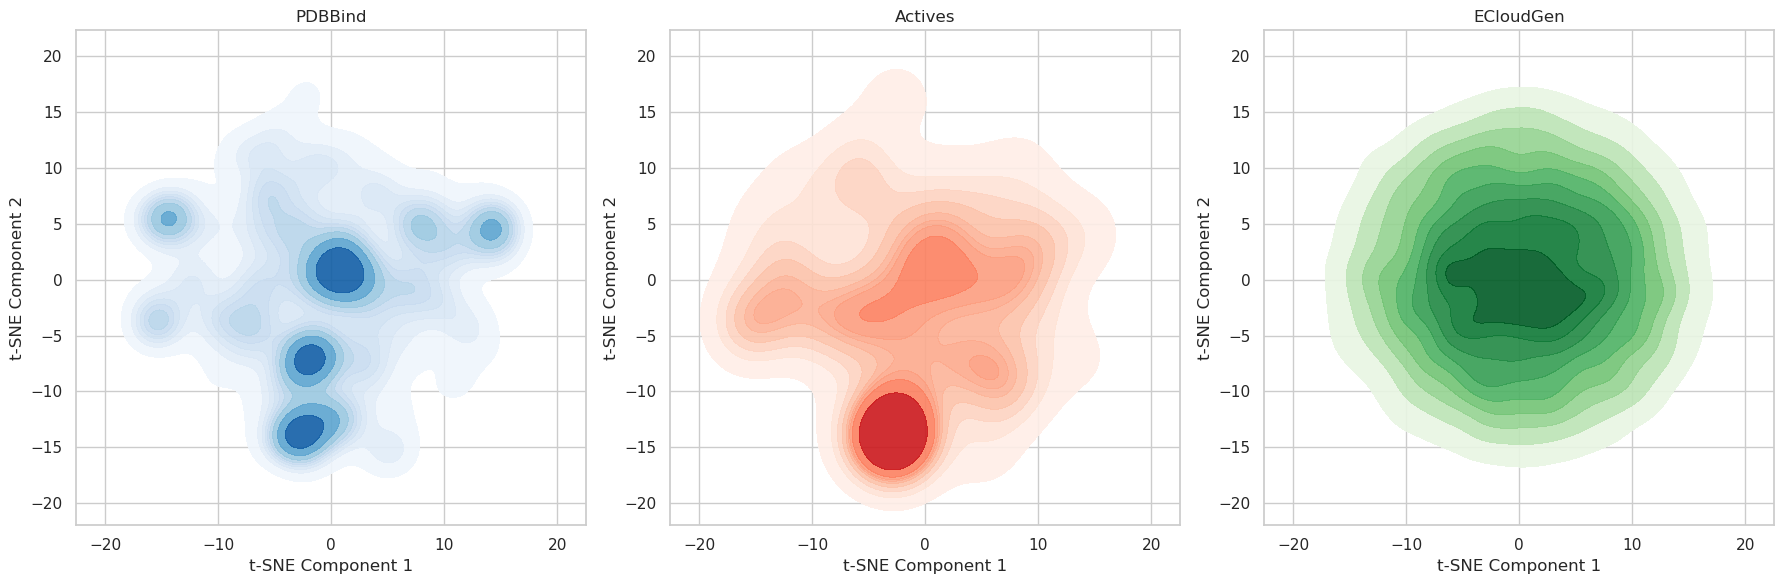

In [179]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming embedded_data1, embedded_data2, embedded_data3 are the transformed datasets
# Calculating the overall min and max for the plotting ranges
all_data = np.vstack([embedded_data1, embedded_data2, embedded_data3])
x_min, x_max = all_data[:, 0].min(), all_data[:, 0].max()
y_min, y_max = all_data[:, 1].min(), all_data[:, 1].max()

# Extending the range slightly for visual comfort
x_range = [x_min - 5, x_max + 5]
y_range = [y_min - 5, y_max + 5]

# Setup the plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Data 1 Plot
sns.kdeplot(x=embedded_data1[:, 0], y=embedded_data1[:, 1], ax=axes[0], cmap="Blues", fill=True, alpha=0.9)
axes[0].set_title('PDBBind')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
axes[0].set_xlim(x_range)
axes[0].set_ylim(y_range)

# Data 2 Plot
sns.kdeplot(x=embedded_data2[:, 0], y=embedded_data2[:, 1], ax=axes[1], cmap="Reds", fill=True, alpha=0.9)
axes[1].set_title('Actives')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].set_xlim(x_range)
axes[1].set_ylim(y_range)

# Data 3 Plot
sns.kdeplot(x=embedded_data3[:, 0], y=embedded_data3[:, 1], ax=axes[2], cmap="Greens", fill=True, alpha=0.9)
axes[2].set_title('ECloudGen')
axes[2].set_xlabel('t-SNE Component 1')
axes[2].set_ylabel('t-SNE Component 2')
axes[2].set_xlim(x_range)
axes[2].set_ylim(y_range)

plt.tight_layout()
plt.show()


/home/haotian/software/miniconda3/envs/ecloud/lib/python3.9/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


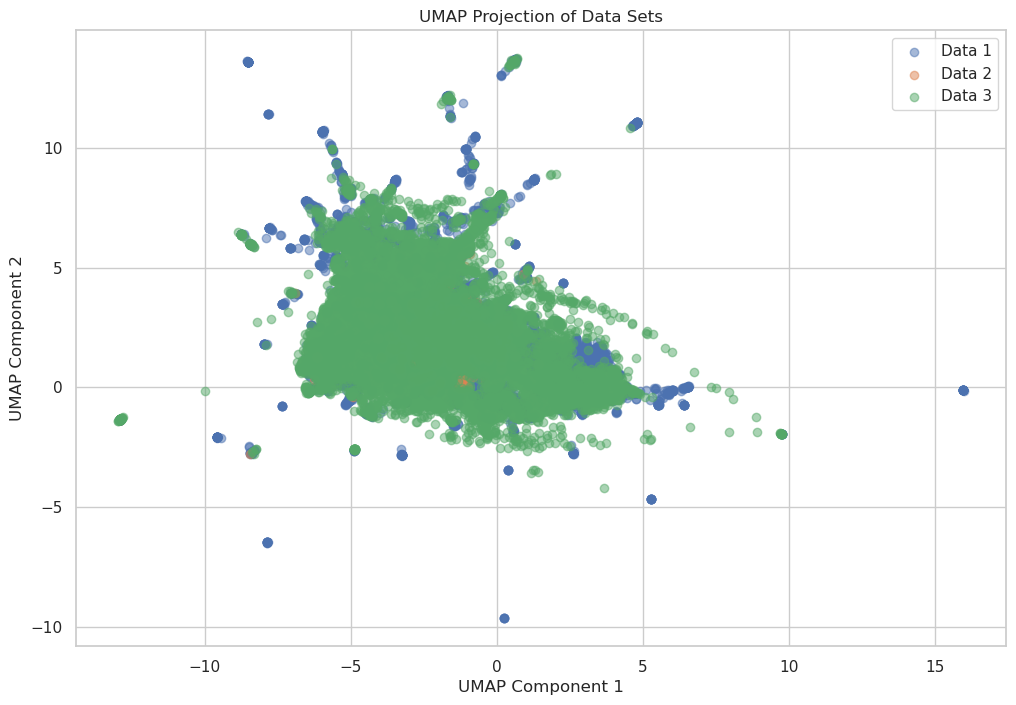

In [180]:
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# 假设 data1, data2, data3 是你的数据集

reducer = umap.UMAP(random_state=42)
embedded_data1 = reducer.fit_transform(data1)  # 使用 data3 拟合并转换

# 假设你还想转换 data1 和 data2
embedded_data2 = reducer.transform(data2)
embedded_data3 = reducer.transform(data3)

# 绘制结果
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
plt.scatter(embedded_data1[:, 0], embedded_data1[:, 1], label='Data 1', alpha=0.5)
plt.scatter(embedded_data2[:, 0], embedded_data2[:, 1], label='Data 2', alpha=0.5)
plt.scatter(embedded_data3[:, 0], embedded_data3[:, 1], label='Data 3', alpha=0.5)
plt.title('UMAP Projection of Data Sets')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend()
plt.show()


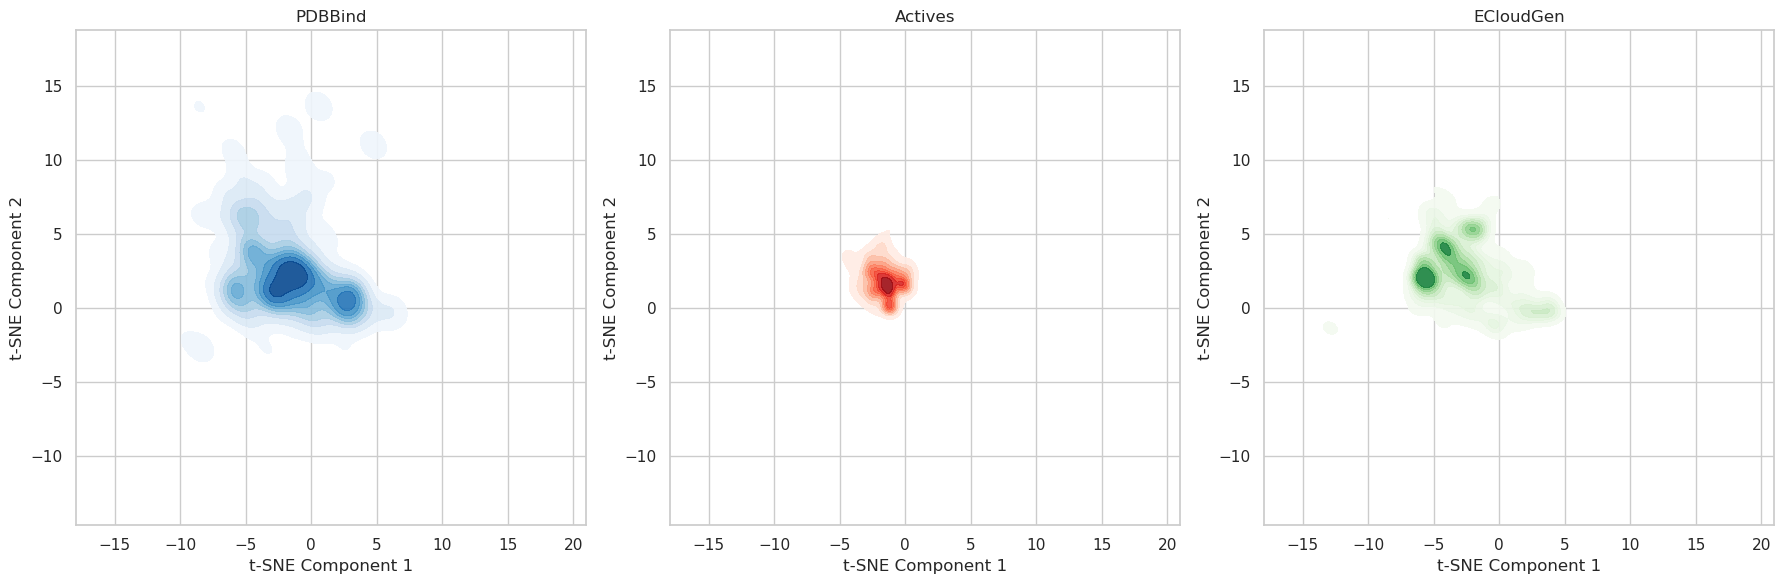

In [182]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming embedded_data1, embedded_data2, embedded_data3 are the transformed datasets
# Calculating the overall min and max for the plotting ranges
all_data = np.vstack([embedded_data1, embedded_data2, embedded_data3])
x_min, x_max = all_data[:, 0].min(), all_data[:, 0].max()
y_min, y_max = all_data[:, 1].min(), all_data[:, 1].max()

# Extending the range slightly for visual comfort
x_range = [x_min - 5, x_max + 5]
y_range = [y_min - 5, y_max + 5]

# Setup the plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns

# Data 1 Plot
sns.kdeplot(x=embedded_data1[:, 0], y=embedded_data1[:, 1], ax=axes[0], cmap="Blues", fill=True, alpha=0.9)
axes[0].set_title('PDBBind')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
axes[0].set_xlim(x_range)
axes[0].set_ylim(y_range)

# Data 2 Plot
sns.kdeplot(x=embedded_data2[:, 0], y=embedded_data2[:, 1], ax=axes[1], cmap="Reds", fill=True, alpha=0.9)
axes[1].set_title('Actives')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].set_xlim(x_range)
axes[1].set_ylim(y_range)

# Data 3 Plot
sns.kdeplot(x=embedded_data3[:, 0], y=embedded_data3[:, 1], ax=axes[2], cmap="Greens", fill=True, alpha=0.9)
axes[2].set_title('ECloudGen')
axes[2].set_xlabel('t-SNE Component 1')
axes[2].set_ylabel('t-SNE Component 2')
axes[2].set_xlim(x_range)
axes[2].set_ylim(y_range)

plt.tight_layout()
plt.show()


In [219]:
traj = read_pkl('./results/conditions_tmp/pic50_0.pkl')[1:]


# determine a top hits threshold.
upper_quant = 0.9
hit_threshold = np.quantile(
    [x["pic50"] for x in traj[:]], upper_quant
)

max_score = max([x["pic50"] for x in traj[:]])
print(f"hit threshold: {hit_threshold}, max score: {max_score}\n")

# compare generated hits to known results
gen_hits = [
    v
    for v in traj[:]
    if v["pic50"] >= hit_threshold # and v["qed"] >= 0.5
]
known_results = [v for v in act_smi_pic50]

# compute cosine similarity between generated hits and known results
t1 = np.array([v["emb"] for v in gen_hits])
t2 = np.array([v["emb_smiles"] for v in known_results])
t1 /= np.sqrt(np.einsum("ij,ij->i", t1, t1))[:, np.newaxis]
t2 /= np.sqrt(np.einsum("ij,ij->i", t2, t2))[:, np.newaxis]
sims = np.einsum("ij,kj->ik", t1, t2)
i, j = np.stack(np.where(sims == sims.max()), 0)[:, 0]


sims = np.einsum("ij,kj->ik", t1, t2)
near_mols = []
near_mol_pic50s = []
closest_n = 10
for k in range(0, closest_n):
    near_mols.append(
        Chem.MolFromSmiles(known_results[np.argsort(sims)[i][~k]]["smiles"])
    )
    near_mol_pic50s.append(known_results[np.argsort(sims)[i][~k]]["pic50"])

# img = Chem.Draw.MolsToGridImage(
#     near_mols,
#     molsPerRow=4,  # useSVG=True,
#     legends=["pIC50: " + f"{near_mol_pic50s[k]}" for k in range(closest_n)],
# )
# img

hit threshold: 7.59904408454895, max score: 9.913955688476562



In [216]:
from PIL import Image
import io
def save_img(ipy_Image, out_file):
    img_byte_arr = io.BytesIO(ipy_Image.data)
    img_pil = Image.open(img_byte_arr)
    img_pil.save(out_file)
    print('saved at {}'.format(out_file))

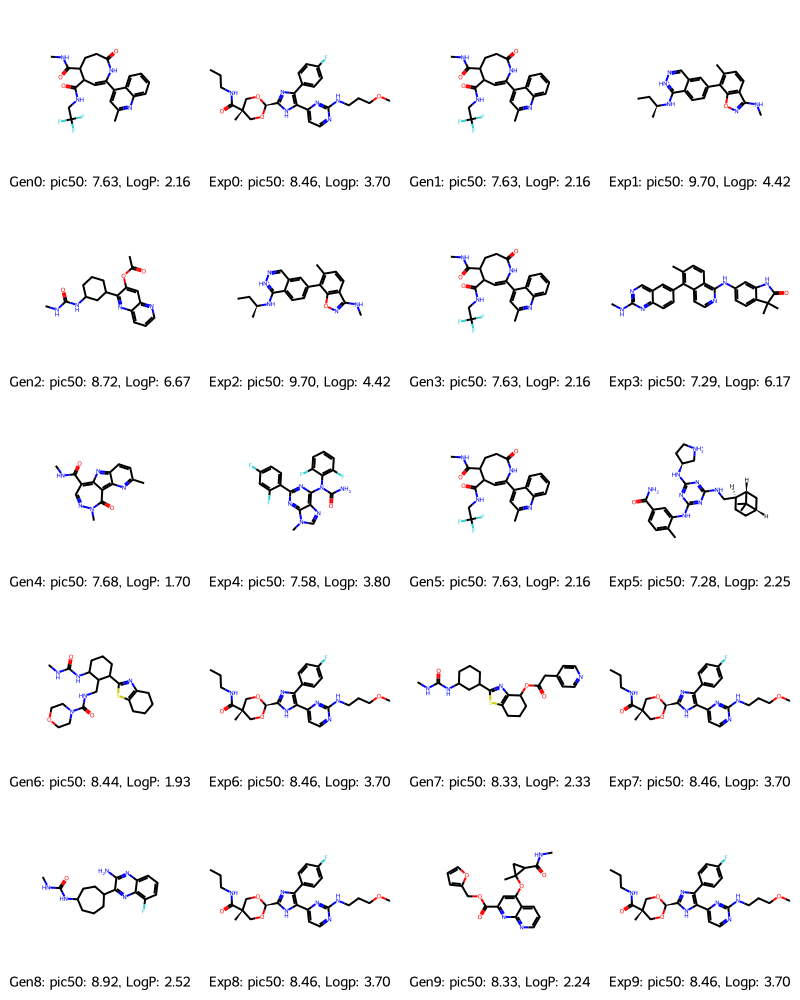

In [221]:

from rdkit.Chem import Draw

# 假设 sims, gen_hits, known_results 已经定义好了

# 获取所有相似度的排序索引，从高到低
sorted_indices = np.dstack(np.unravel_index(np.argsort(-sims.ravel()), sims.shape))[0]

# 取前10个最相似的对
top_n = 10
top_pairs = sorted_indices[:top_n]

# 准备数据以显示最相似的对
mols_gen = []
mols_to_draw = []
legends = []

for ind, index_pair in enumerate(top_pairs):
    i, j = index_pair
    gen_hit =gen_hits[i]
    gen_hit_mol =  Chem.MolFromSmiles(gen_hit['smiles'])
    known_result = known_results[j]
    known_result_mol = Chem.MolFromSmiles(known_result['smiles'])
    mols_to_draw.append(gen_hit_mol)
    mols_to_draw.append(known_result_mol)
    sim_score = sims[i, j]
    legends.append(f"Gen{ind}: pic50: {gen_hit['pic50']:.2f}, LogP: {gen_hit['logp']:.2f}")
    legends.append(f"Exp{ind}: pic50: {known_result['pic50']:.2f}, Logp: {known_result['logp']:.2f}")


# 绘制最相似的化合物对
img = Draw.MolsToGridImage(
    mols_to_draw,
    molsPerRow=4,  # 每行显示两个化合物（一对）
    subImgSize=(200, 200),  # 可调整子图大小
    legends=legends  # 显示图例
)
img  # 显示图像


In [222]:

from rdkit.Chem import Draw

# 假设 sims, gen_hits, known_results 已经定义好了

# 获取所有相似度的排序索引，从高到低
sorted_indices = np.dstack(np.unravel_index(np.argsort(-sims.ravel()), sims.shape))[0]

# 取前10个最相似的对
top_n = 10
top_pairs = sorted_indices[:top_n]

# 准备数据以显示最相似的对
mols_gen = []
mols_known = []
legends_gen = []
legends_known = []
for ind, index_pair in enumerate(top_pairs):
    i, j = index_pair
    gen_hit =gen_hits[i]
    gen_hit_mol =  Chem.MolFromSmiles(gen_hit['smiles'])
    known_result = known_results[j]
    known_result_mol = Chem.MolFromSmiles(known_result['smiles'])
    mols_gen.append(gen_hit_mol)
    mols_known.append(known_result_mol)
    sim_score = sims[i, j]
    legends_gen.append(f"pic50: {gen_hit['pic50']:.2f}, LogP: {gen_hit['logp']:.2f}")
    legends_known.append(f"pic50: {known_result['pic50']:.2f}, Logp: {known_result['logp']:.2f}")

for i in range(len(mols_gen)):
    img = Draw.MolsToGridImage(mols_gen[i:i+1], molsPerRow=1, subImgSize=(200, 200), legends=legends_gen[i:i+1])
    save_img(img, f'./results/mk14_traj0_figures/gen_{i}.png')
    img = Draw.MolsToGridImage(mols_known[i:i+1], molsPerRow=1, subImgSize=(200, 200), legends=legends_known[i:i+1])
    save_img(img, f'./results/mk14_traj0_figures/known_{i}.png')

saved at ./results/mk14_traj0_figures/gen_0.png
saved at ./results/mk14_traj0_figures/known_0.png
saved at ./results/mk14_traj0_figures/gen_1.png
saved at ./results/mk14_traj0_figures/known_1.png
saved at ./results/mk14_traj0_figures/gen_2.png
saved at ./results/mk14_traj0_figures/known_2.png
saved at ./results/mk14_traj0_figures/gen_3.png
saved at ./results/mk14_traj0_figures/known_3.png
saved at ./results/mk14_traj0_figures/gen_4.png
saved at ./results/mk14_traj0_figures/known_4.png
saved at ./results/mk14_traj0_figures/gen_5.png
saved at ./results/mk14_traj0_figures/known_5.png
saved at ./results/mk14_traj0_figures/gen_6.png
saved at ./results/mk14_traj0_figures/known_6.png
saved at ./results/mk14_traj0_figures/gen_7.png
saved at ./results/mk14_traj0_figures/known_7.png
saved at ./results/mk14_traj0_figures/gen_8.png
saved at ./results/mk14_traj0_figures/known_8.png
saved at ./results/mk14_traj0_figures/gen_9.png
saved at ./results/mk14_traj0_figures/known_9.png


In [230]:
init_traj = read_pkl('./results/conditions_tmp/mk14_init.pkl')
init_mols = [Chem.MolFromSmiles(i['smiles']) for i in init_traj]
init_legends = [f"pic50: {i['pic50']:.2f}, LogP: {i['logp']:.2f}" for i in init_traj]

for i in range(len(init_mols)): 
    img = Draw.MolsToGridImage(init_mols[i:i+1], molsPerRow=1, subImgSize=(200, 200), legends=init_legends[i:i+1])
    save_img(img, f'./results/mk14_traj0_figures/init_{i}.png')

saved at ./results/mk14_traj0_figures/init_0.png
saved at ./results/mk14_traj0_figures/init_1.png
saved at ./results/mk14_traj0_figures/init_2.png
saved at ./results/mk14_traj0_figures/init_3.png
saved at ./results/mk14_traj0_figures/init_4.png


In [ ]:
truncate = 1000
logps = [item['logp'] for item in traj][:truncate]
pic50s = [item['pic50'] for item in traj][:truncate]

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

data = pic50s[1:]

x = list(range(len(data)))

colors = sns.color_palette("deep")  # 获取Seaborn的默认深色调色板

fig, ax = plt.subplots(figsize=(8, 4))

# ax.plot(x, data, marker='o', linestyle='-', color=colors[4], alpha=0.6)
ax.plot(x, data, linestyle='-', color=colors[0], alpha=0.6)
ax.grid(True)  # 显示网格
plt.show()

In [ ]:
data = logps[1:]

x = list(range(len(data)))

colors = sns.color_palette("deep")  # 获取Seaborn的默认深色调色板

fig, ax = plt.subplots(figsize=(8, 4))

# ax.plot(x, data, marker='o', linestyle='-', color=colors[4], alpha=0.6)
ax.plot(x, data, linestyle='-', color=colors[0], alpha=0.6)
ax.grid(True)  # 显示网格
plt.show()